<h1>Processo de ETL dos Dados do Telegram</h1>
<hr>
<p><strong>Descrição:</strong> Todo material utilizado para o desenvolvimento desse notebook foi disponibilizado pela <a href="https://ebaconline.com.br/analista-de-dados">EBAC</a>.

<p style="text-align:justify">A etapa de <strong>extração</strong>, <strong>transformação</strong> e <strong>carregamento</strong>, é responsável  pela manipulação dos dados ingeridos de sistemas transacionais, ou seja, já persistidos em camadas cruas ou raw de sistemas analíticos. Os processos conduzidos nesta etapa variam bastante conforme a área da empresa, do volume/variedade/velocidade do dado consumido, etc. Contudo, em geral, o dado cru ingerido passa por um processo recorrente de data wrangling onde o dado é limpo, de duplicado, etc. e persistido com técnicas de particionamento, orientação a coluna e compressão, garantindo que esses dados estejam disponíveis para retirada de insights.</p>
<p style="text-align:justify">No projeto, as mensagens de um único dia, persistidas na camada cru, serão compactas em um único arquivo, orientado a coluna e comprimido, que será persistido em uma camada enriquecida. Além disso, durante este processo, o dado também passará por
etapas de data wrangling.</p>
<p>Passo a passo para realização desses processos:</p>
<ol>
<li>Criação do AWS S3;
<li>Criação da Função AWS Lambda;
<li>Criação do Event Bridge (WorkFlow).
</ol>
<h2>1. Criação do AWS S3</h2>
<p>Na etapa de <strong>ETL</strong>, o AWS S3 tem a função de passivamente armazenar as mensagens
processadas de um dia em um único arquivo no formato Parquet. Para tanto, basta a criação de um bucket. Como padrão, uma sugestão é adicionar o sufixo <code>-enriched</code> ao seu nome.</p>

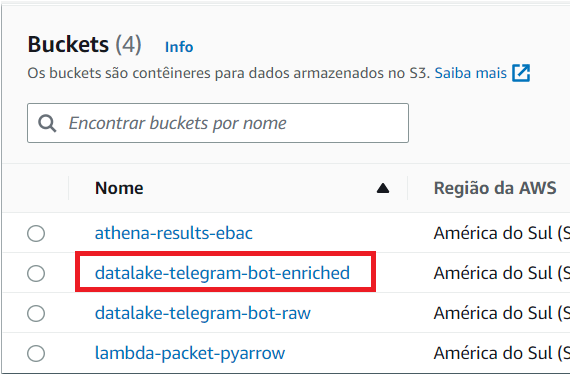

<h2>2. Criação da Função AWS Lambda</h2>
<p style="text-align:justify">O <code>AWS Lambda</code> tem a função de ativamente processar as mensagens
captadas pelo bot do Telegram, persistidas na camada cru no bucket do <code>AWS S3</code> ,e persisti-las na camada enriquecida, também em um bucket do <code>AWS S3</code>. Logo, vamos criar uma função que opera da seguinte forma:</p>

<ul>
<li>Lista todos os arquivos JSON de uma única participação da camada crua de um bucket do <code>AWS S3</code>;
<li>Para cada arquivo listado:
<ul>
<li>Faz o <em>download</em> do arquivo e carrega o conteúdo da mensagem;
<li>Executa uma função de <em>data wrangling</em>;
<li>Cria uma tabela do PyArrow e a contatena com as demais.
</ul>
<li>Persiste a tabela no formato Parquet na camada enriquecida em um bucket do <code>AWS S3</code>.
</ul>
<p>O código da função:</p>

In [ ]:
import os
import json
import logging
from datetime import datetime, timedelta, timezone

import boto3
import pyarrow as pa
import pyarrow.parquet as pq


def lambda_handler(event: dict, context: dict) -> bool:

  '''
  Diariamente é executado para compactar as diversas mensagensm, no formato
  JSON, do dia anterior, armazenadas no bucket de dados cru, em um único 
  arquivo no formato PARQUET, armazenando-o no bucket de dados enriquecidos
  '''

  # vars de ambiente

  RAW_BUCKET = os.environ['AWS_S3_BUCKET']
  ENRICHED_BUCKET = os.environ['AWS_S3_ENRICHED']

  # vars lógicas

  tzinfo = timezone(offset=timedelta(hours=-3))
  date = (datetime.now(tzinfo) - timedelta(days=1)).strftime('%Y-%m-%d')
  timestamp = datetime.now(tzinfo).strftime('%Y%m%d%H%M%S%f')

  # código principal

  table = None
  client = boto3.client('s3')

  try:

      response = client.list_objects_v2(Bucket=RAW_BUCKET, Prefix=f'telegram/context_date={date}')

      for content in response['Contents']:

        key = content['Key']
        client.download_file(RAW_BUCKET, key, f"/tmp/{key.split('/')[-1]}")

        with open(f"/tmp/{key.split('/')[-1]}", mode='r', encoding='utf8') as fp:

          data = json.load(fp)
          data = data["message"]

        parsed_data = parse_data(data=data)
        iter_table = pa.Table.from_pydict(mapping=parsed_data)

        if table:

          table = pa.concat_tables([table, iter_table])

        else:

          table = iter_table
          iter_table = None
          
      pq.write_table(table=table, where=f'/tmp/{timestamp}.parquet')
      client.upload_file(f"/tmp/{timestamp}.parquet", ENRICHED_BUCKET, f"telegram/context_date={date}/{timestamp}.parquet")

      return True
  
  except Exception as exc:
      logging.error(msg=exc)
      return False
      
# O código da função de data wrangling:     
def parse_data(data: dict) -> dict:

  date = datetime.now().strftime('%Y-%m-%d')
  timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

  parsed_data = dict()

  for key, value in data.items():

      if key == 'from':
          for k, v in data[key].items():
              if k in ['id', 'is_bot', 'first_name']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key == 'chat':
          for k, v in data[key].items():
              if k in ['id', 'type']:
                parsed_data[f"{key if key == 'chat' else 'user'}_{k}"] = [v]

      elif key in ['message_id', 'date', 'text']:
          parsed_data[key] = [value]

  if not 'text' in parsed_data.keys():
    parsed_data['text'] = [None]

  return parsed_data

<p><strong>OBS:</strong> Para que a função funcione corretamente, algumas configurações precisam ser
realizadas.</p>
<ul>
  <li>Precisa criar as Variáveis de ambiente:
  <ul>
    <p style="text-align:justify">Note que o código exige a configuração de duas variáveis de ambiente: <code>AWS_S3_BUCKET</code> e <code>AWS_S3_ENRICHED</code> com os nomes dos bucket do <code>AWS S3</code> da camada cru e enriquecida, respectivamente. Para adicionar variáveis de ambiente em uma função do AWS Lambda , basta acessar configurações -> variáveis de ambiente no console da função.</p>
    </ul>
  <li>Precisa liberar a Permissão:
  <ul>
    <p style="text-align:justify">Será preciso adicionar a permissão de escrita nos buckets do AWS S3 para a função do <code>AWS Lambda</code> no <code>AWS IAM</code>.</p></ul>
    <li><mark>Atenção com o Recursos da função lambda:</mark>
  <ul>
  <p style="text-align:justify">O <em>timeout</em> padrão de funcões do <code>AWS Lambda</code> é de 3 segundos. Para essa função, será preciso aumentar o tempo para 5 minutos, principalmente para lidar com o input e output de arquivos do <code>AWS S3</code>.</p>
  <li>Liberar as Camadas:
    <ul>
      <p style="text-align:justify">Por fim, note que o código da função utiliza o pacote <strong>Python PyArrow</strong>. Contudo, o ambiente padrão do <code>AWS Lambda</code> possui poucos pacotes externos instalado, como o
    pacote <strong>Python boto3</strong>, logo o PyArrow não será encontrado e a execução da função falhará. Existem algumas formas de adicionar pacotes externos no ambiente de execução do AWS Lambda, um deles é a criação de camadas ou layers, onde é possível realizar o upload dos pacotes Python direto na plataforma ou através de um bucket do AWS S3. Para esse caso, pretendo seguir com a última opção, desta forma:</p>
      <ul>
        <li>Criar um bucket no AWS S3 ;
        <li>Fazer o upload do código do pacote Python do PyArrow (<a href="https://github.com/aws/aws-sdk-pandas/releases">link</a>);
        <li>Criar layer e conectar na função.
      </ul>
  </ul>
</ul>
<br>
<h2>3. Criação do Event Bridge</h2>
<p style="text-align:justify">Na etapa de ETL, o <code>AWS Event Bridge</code> tem a função de ativar diariamente a função de ETL do AWS Lambda , funcionando assim como um scheduler.</p>

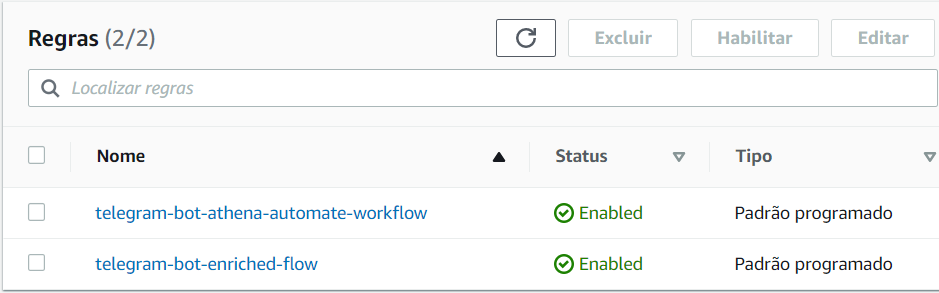